<a href="https://www.kaggle.com/code/chalseo/bank-churn-binary-classification?scriptVersionId=252144561" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# S4E1 Challenge Bank Churn Binary Classification

## Introduction
The goal of this Kaggle competition is to use various factors to predict bank customer churn through binary classification. For this submission, I utilize XGBoostClassifier for classification and hyperparameter optimization as well as matplotlib and seaborn for data visualization.

### Table of Contents:
* [Import Libraries](#section-one)
* [Data Summary & Overview](#section-two)
* [Exploratory Data Analysis](#section-three)
* [Model Building](#section-four)
* [Hyperparameter Optimization](#section-five)
* [Predictions using Test Data](#section-six)

In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns
from matplotlib import pyplot as plt
from xgboost import XGBClassifier, plot_importance

from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

print("Features: ", "\n", train_data.columns.values)
print("\n", "Train data shape: ", train_data.shape)
print("\n", "Test data shape: ", test_data.shape)

print("\n Number of Null Values: ", train_data.isna().astype('int').sum().sum())

Features:  
 ['id' 'CustomerId' 'Surname' 'CreditScore' 'Geography' 'Gender' 'Age'
 'Tenure' 'Balance' 'NumOfProducts' 'HasCrCard' 'IsActiveMember'
 'EstimatedSalary' 'Exited']

 Train data shape:  (165034, 14)

 Test data shape:  (110023, 13)

 Number of Null Values:  0


In [3]:
numerical_features = ['Age', 'Balance', 'CreditScore',  'EstimatedSalary', 'NumOfProducts', 'Tenure']
train_data = train_data.drop_duplicates()

train_data[numerical_features + ['Exited']].describe(percentiles=[]).T.drop(columns=['count'])
train_data.Exited = np.where(train_data.Exited == 1.0, "Yes", "No")

In [4]:
train_data.HasCrCard = np.where(train_data.HasCrCard == 1.0, "Yes", "No")
train_data.IsActiveMember = np.where(train_data.IsActiveMember == 1.0, "Yes", "No")

categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
train_data[categorical_features].describe().T

,count,unique,top,freq
Geography,165034,3,France,94215
Gender,165034,2,Male,93150
HasCrCard,165034,2,Yes,124428
IsActiveMember,165034,2,No,82885


<a id="section-three"></a>
## Exploratory Data Analysis 

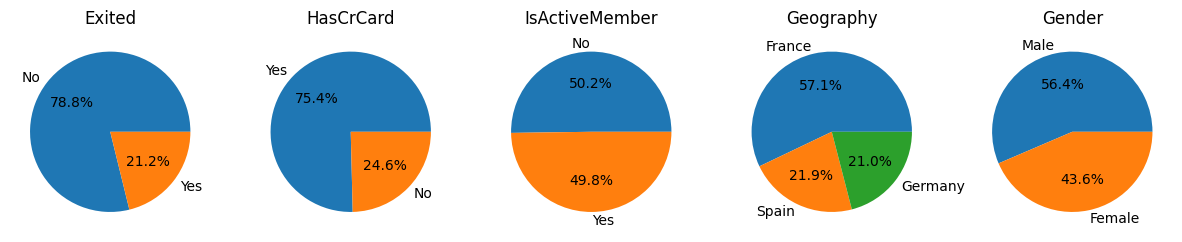

In [5]:
def get_pies(feature_list):
    fig, axs = plt.subplots(1, len(feature_list), figsize=(15, 5))
    
    for i, feature in enumerate(feature_list):
        pie_data = train_data[feature].value_counts()
        axs[i].pie(pie_data, labels = pie_data.index, autopct = '%1.1f%%')
        axs[i].set_title(feature)

    plt.show()

get_pies(["Exited", "HasCrCard", "IsActiveMember", "Geography", "Gender"])

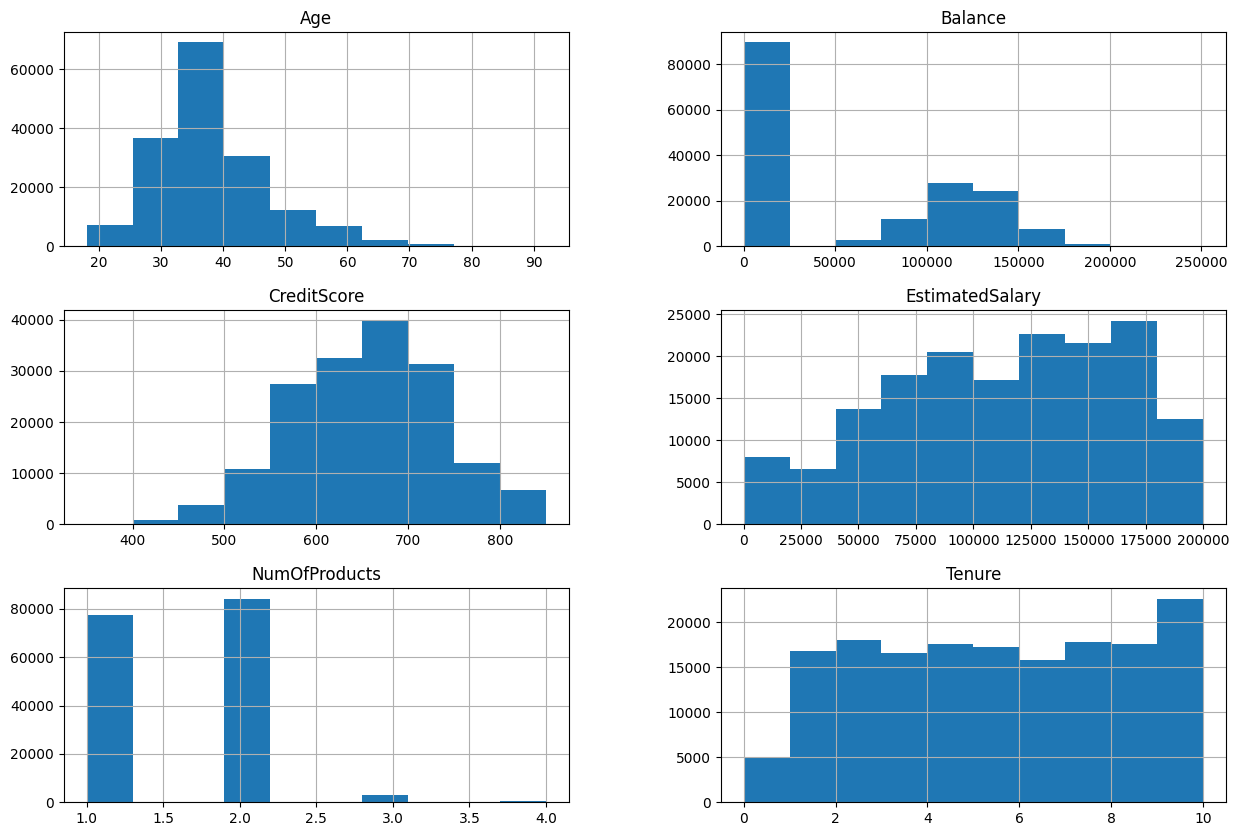

In [6]:
train_data.hist(column=numerical_features, figsize=(15,10))
plt.show()

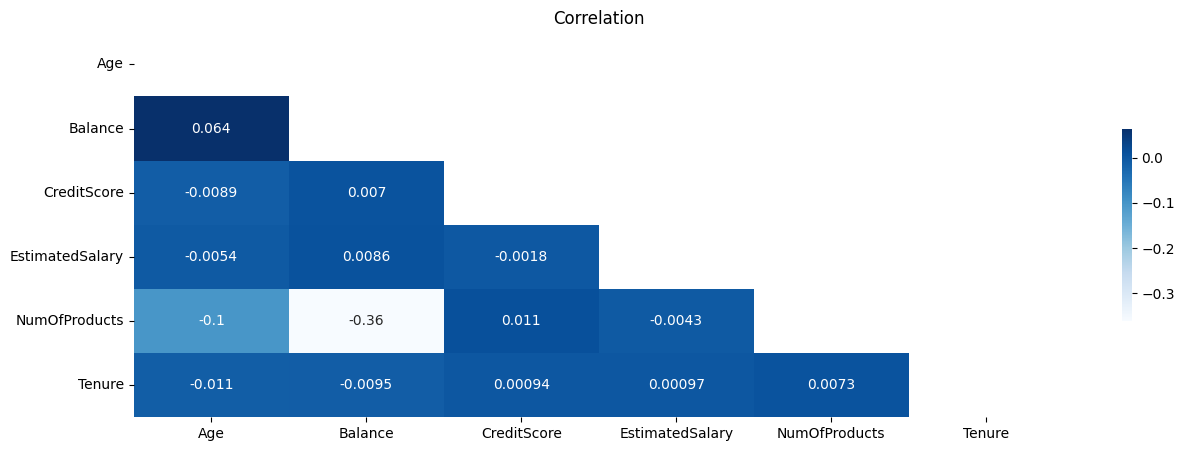

In [7]:
corr = train_data[numerical_features].corr()
plt.figure(figsize=(15, 5))
sns.heatmap(corr, mask=np.triu(corr), annot=True, cmap='Blues', cbar_kws={"shrink": .5})
plt.title("Correlation")
plt.show()

<a id="section-four"></a>
## Model Building 

In [8]:
def create_features(df):
    df['SurnameLength'] = df.Surname.apply(lambda s: len(s))
    return df

train_df = create_features(train_data).drop(columns=['id', 'CustomerId', 'Surname', 'Exited'])
test_df = create_features(test_data).drop(columns=['id', 'CustomerId', 'Surname'])

test_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,SurnameLength
0,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75,8
1,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27,4
2,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09,2
3,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57,9
4,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00,7


In [9]:
transformer = make_column_transformer(
    (RobustScaler(), numerical_features),
    (OneHotEncoder(), categorical_features), sparse_threshold=0)
transformed_data = transformer.fit_transform(train_data)

feature_names = [name.split("__")[-1] for name in transformer.get_feature_names_out()]
X = pd.DataFrame(transformed_data, columns=feature_names)
y = np.where(train_data.Exited == "Yes", 1, 0)

transformed_data = transformer.fit_transform(test_data)
X_pred = pd.DataFrame(transformed_data, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
print("Complete set of features: ", "\n", X_train.columns.values)

Complete set of features:  
 ['Age' 'Balance' 'CreditScore' 'EstimatedSalary' 'NumOfProducts' 'Tenure'
 'Geography_France' 'Geography_Germany' 'Geography_Spain' 'Gender_Female'
 'Gender_Male' 'HasCrCard_No' 'HasCrCard_Yes' 'IsActiveMember_No'
 'IsActiveMember_Yes']


In [10]:
clf = XGBClassifier(objective='binary:logistic', 
                    eval_metric='auc',
                    validate_parameters=True,
                    random_state=42,
                    n_jobs=-1)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("AUC: %.2f%%" % (round(roc_auc_score(y_test, y_pred) * 100, 2)))

AUC: 75.06%


<a id="section-five"></a>
## Hyperparameter Optimization 

In [11]:
# Cross-validation
target = train_data.Exited.value_counts()
rs_params = {
 "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree": [ 0.3, 0.4, 0.5 , 0.7 ],
 "scale_pos_weight": [target[0]/target[1]] 
}

rs_clf = RandomizedSearchCV(estimator=clf, 
                            scoring='roc_auc',
                            param_distributions=rs_params, 
                            random_state=42,
                            n_jobs=-1,
                            cv=5)
rs_clf.fit(X_train, y_train)

print("Best set of hyperparameters: ", "\n", rs_clf.best_params_)
print("AUC-ROC score: %.2f%%" % round(rs_clf.best_score_ * 100, 2))

Best set of hyperparameters:  
 {'scale_pos_weight': 3.72592422897397, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.4}
AUC-ROC score: 88.88%


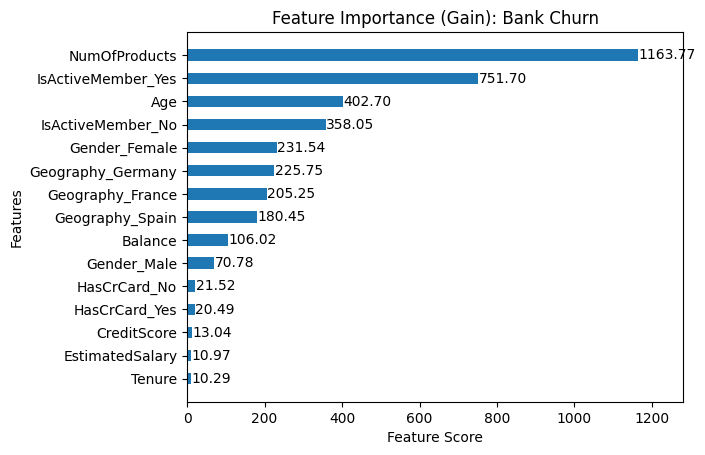

In [12]:
rs_importances = rs_clf.best_estimator_.get_booster().get_score(importance_type='gain')
plot_importance(rs_importances, max_num_features=20, grid=False, height=.5,
                title="Feature Importance (Gain): Bank Churn", values_format="{v:.2f}")
plt.xlabel("Feature Score")
plt.show()

<a id="section-six"></a>
## Predictions using Test Data

In [13]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv', index_col='id')
submission['Exited'] = rs_clf.best_estimator_.predict_proba(X_pred)[:,1]
submission.head()

,Exited
id,
165034,0.100529
165035,0.944790
165036,0.100111
165037,0.504242
165038,0.690352


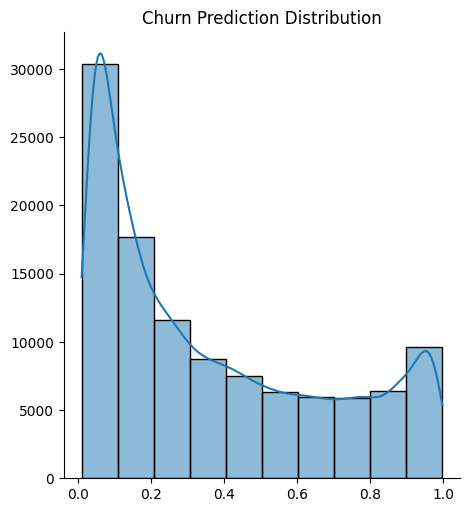

In [14]:
sns.displot(submission, kde=True, bins=10, legend=False)
plt.title("Churn Prediction Distribution")
plt.xlabel(None)
plt.ylabel(None)
plt.show()

In [15]:
submission.to_csv('submission.csv')